In [2]:
from transformers import AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec


# Load GPT-2 base model (no LM head)
model_name = "gpt2"
model = AutoModel.from_pretrained(model_name)

positional_encodings = model.wpe.weight.detach().cpu().numpy()
# Normalize for better comparison with other encodings
normed_pe = positional_encodings / np.linalg.norm(positional_encodings, axis=1, keepdims=True)
print(positional_encodings.shape)  # Should be (1024, 768)


L = 1024
def sinusoidal_positional_encoding(max_len, d_model):
    pe = np.zeros((max_len, d_model)) # Initialize the PE matrix with all zeros
    position = np.arange(0, max_len)[:, np.newaxis] # Column vector of positions
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(L) / d_model)) # define the frequencies
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

sinusoidal_encodings = sinusoidal_positional_encoding(L, 768)
normed_se = sinusoidal_encodings / np.linalg.norm(sinusoidal_encodings, axis=1, keepdims=True)



# Norms

gpt2_norms = np.linalg.norm(positional_encodings, axis=1)
sine_norms = np.linalg.norm(sinusoidal_encodings, axis=1)


# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity between each Pn and Pn+1
cos_sim = [
    cosine_similarity([positional_encodings[i]], [positional_encodings[i+1]])[0, 0] # [0,0] estracts the scalar similarity value from the resulting 1x1 matrix
    for i in range(len(positional_encodings) - 1)
]
cos_sim_sine = [
    cosine_similarity([sinusoidal_encodings[i]], [sinusoidal_encodings[i+1]])[0, 0]
    for i in range(len(sinusoidal_encodings) - 1)
]

(1024, 768)


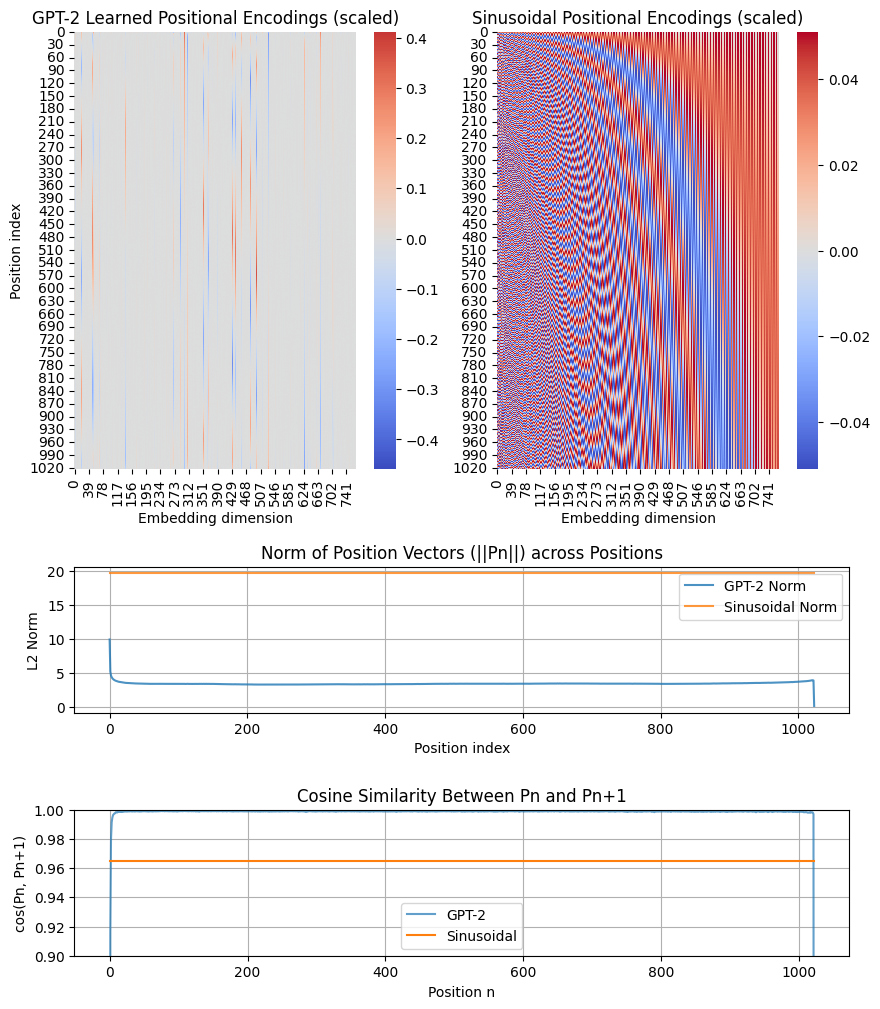

In [3]:

fig = plt.figure(figsize = (10, 12))
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[3, 1, 1], width_ratios=[1,1])
# Example: ax1 takes the left two-thirds of the top row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])


#sns.heatmap(positional_encodings, cmap="coolwarm", center = 0)
ax = ax1
sns.heatmap(normed_pe, ax = ax, cmap="coolwarm", center = 0)
ax.set_title("GPT-2 Learned Positional Encodings (scaled)")
ax.set_xlabel("Embedding dimension")
ax.set_ylabel("Position index")

ax = ax2
#sns.heatmap(sinusoidal_encodings, cmap="coolwarm", center = 0)
sns.heatmap(normed_se, ax = ax, cmap="coolwarm", center = 0)
ax.set_title("Sinusoidal Positional Encodings (scaled)")
ax.set_xlabel("Embedding dimension")
#plt.ylabel("Position index")

ax = ax3

ax.plot(gpt2_norms, label="GPT-2 Norm", alpha=0.8)
ax.plot(sine_norms, label="Sinusoidal Norm", alpha=0.8)
ax.set_title("Norm of Position Vectors (||Pn||) across Positions")
ax.set_xlabel("Position index")
ax.set_ylabel("L2 Norm")
#plt.xlim(1020,1025)
#plt.ylim(2.5,5)
#plt.ylim(0,1)
ax.legend()
ax.grid(True)



ax = ax4

ax.plot(cos_sim, label="GPT-2", alpha=0.7)
ax.plot(cos_sim_sine, label="Sinusoidal")
#plt.xlim(0,25)
ax.set_ylim((0.9, 1))
ax.set_title("Cosine Similarity Between Pn and Pn+1")
ax.set_xlabel("Position n")
ax.set_ylabel("cos(Pn, Pn+1)")
ax.legend()
ax.grid(True)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
plt.show()

# Can tokens overlap after positional encoding is added?


We compute the distribution of the pairwise distance between tokens in the embedding space and the average, $d$. Then we check if $2\cdot ||P_n|| > d $ (condition for overlapping).

### How the embedding space is made

**!** code below takes 1 minute

In [3]:
embedding_matrix = model.get_input_embeddings().weight.detach().cpu().numpy()

# Compute L2 norms of each token vector
token_norms = np.linalg.norm(embedding_matrix, axis=1)

from sklearn.metrics.pairwise import cosine_similarity

embedding_matrix_reduced = embedding_matrix[np.random.choice(a = 50257, size = 50257//10, replace = False), :]
cosine = cosine_similarity(embedding_matrix_reduced, embedding_matrix_reduced)
cosine.shape

(5025, 5025)

In [5]:
for i in range(cosine.shape[0]):
    cosine[i, i] = np.nan
cosine = cosine.flatten() 

Average token embedding norm: 3.9585
Standard deviation: 0.4337
Max norm: 6.3155
Min norm: 2.4537


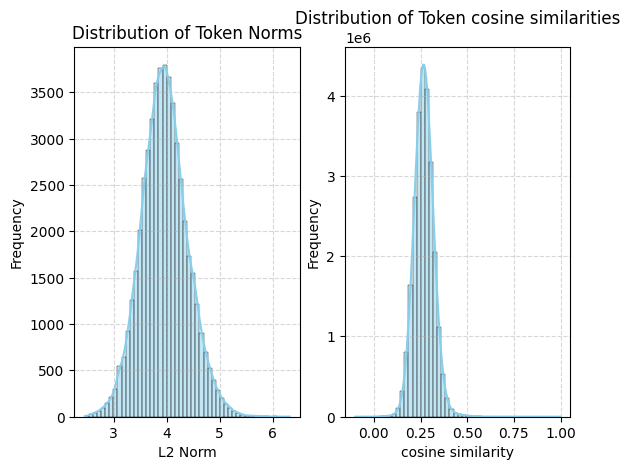

In [6]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)

ax = axs[0]
sns.histplot(token_norms, ax = ax, bins=50, kde=True, color="skyblue", edgecolor="black")
ax.set_title("Distribution of Token Norms")
ax.set_xlabel("L2 Norm")
ax.set_ylabel("Frequency")
ax.grid(True, linestyle='--', alpha=0.5)

ax = axs[1]
sns.histplot(cosine, ax = ax, bins=50, kde=True, color="skyblue", edgecolor="black")
ax.set_title("Distribution of Token cosine similarities")
ax.set_xlabel("cosine similarity")
ax.set_ylabel("Frequency")
ax.grid(True, linestyle='--', alpha=0.5)


# Statistics
mean_norm = np.mean(token_norms)
std_norm = np.std(token_norms)
max_norm = np.max(token_norms)
min_norm = np.min(token_norms)

print(f"Average token embedding norm: {mean_norm:.4f}")
print(f"Standard deviation: {std_norm:.4f}")
print(f"Max norm: {max_norm:.4f}")
print(f"Min norm: {min_norm:.4f}")

In [25]:
d = mean_norm # mean distance between centers of hyperspheres
r = np.mean(gpt2_norms[1:-1]) # mean radius
print(d, r, 2*r)

3.9585361 3.386918 6.773836


Yes: the hyperspheres **do** overlap. 

But since we are in very high dimension, the volume concentrates near the surface of the sphere, so the volume of the intersection is totally **negligible**.

Similarly, the volume of the intersection between the two hypersphere's surfaces is negligible.

Practically: even if the spheres intersect, there is virtually no chance that different tokens get mapped to the same vector after positional encoding.

In [ ]:
from scipy.special import betainc

def intersection_fraction(n, d, r):
    if d >= 2 * r:
        return 0.0
    x = 1 - (d / (2 * r))**2
    return betainc((n + 1)/2, 0.5, x)


In [26]:
mean_overlap_volume = intersection_fraction(n = embedding_matrix.shape[1], d = mean_norm, r = r)
mean_overlap_volume

np.float32(0.0)

### Fourier Analysis

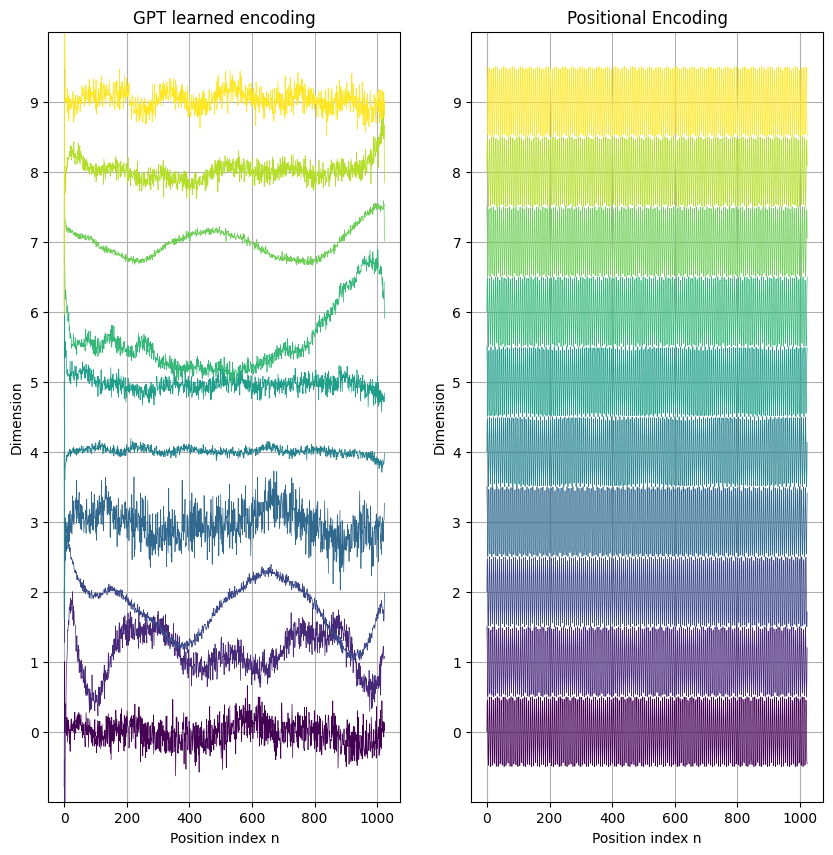

In [26]:
def plot_encoding(encoding, dims_to_plot, ax,title = "", scaling = 0.2, l = 0.5):
    cmap = plt.get_cmap('viridis', len(dims_to_plot)) 
    offset = 0.2
    for i, dim in enumerate(dims_to_plot):
        p = encoding[:, dim]
        p_scaled = p / np.max(p) * scaling
        ax.plot(p_scaled + i * offset, color = cmap(i), linewidth = l)

    ax.set_xlabel("Position index n")
    ax.set_ylabel("Dimension")
    yticks_positions = np.arange(0, len(dims_to_plot)) * offset
    ax.set_yticks(yticks_positions)
    ax.set_yticklabels(dims_to_plot)
    ax.set_ylim(-offset, len(dims_to_plot) * offset )
    ax.set_title(title)
    ax.grid()




fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10))
N = 10
plot_encoding(positional_encodings, dims_to_plot = np.arange(0, N), ax = axs[0], title = "GPT learned encoding")
plot_encoding(sinusoidal_encodings, dims_to_plot = np.arange(0, N), ax = axs[1], scaling = 0.1, title = "Positional Encoding")
plt.show()

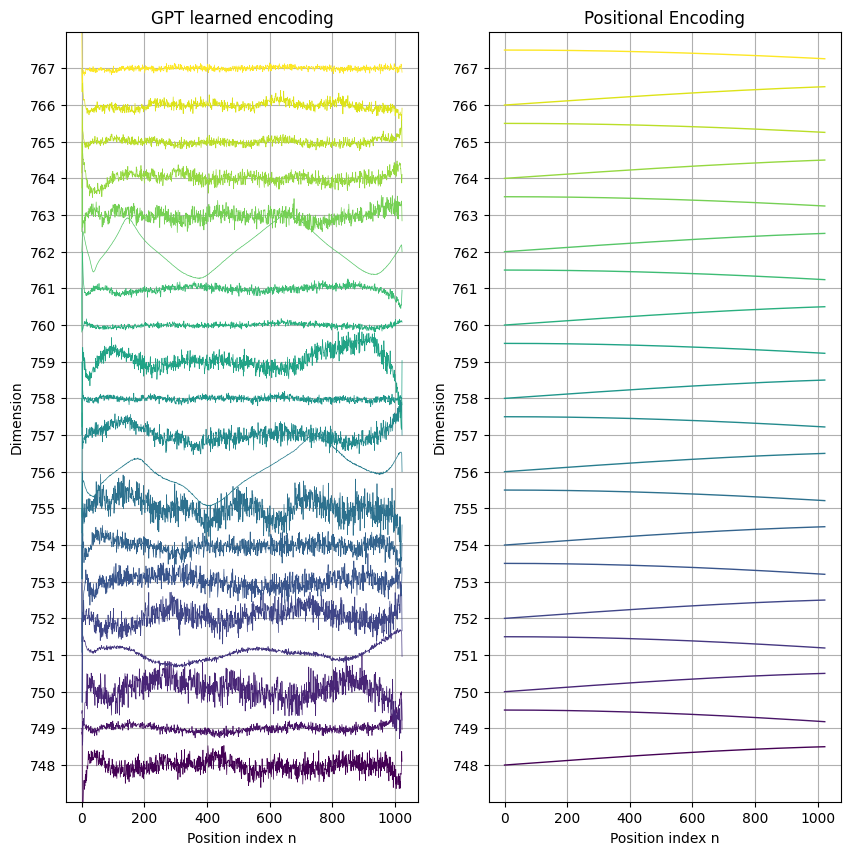

In [27]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10))
N = 20
plot_encoding(positional_encodings, dims_to_plot = np.arange(768-N, 768), ax = axs[0], title = "GPT learned encoding")
plot_encoding(sinusoidal_encodings, dims_to_plot = np.arange(768-N, 768), ax = axs[1], scaling = 0.1, l =1, title = "Positional Encoding")
plt.show()

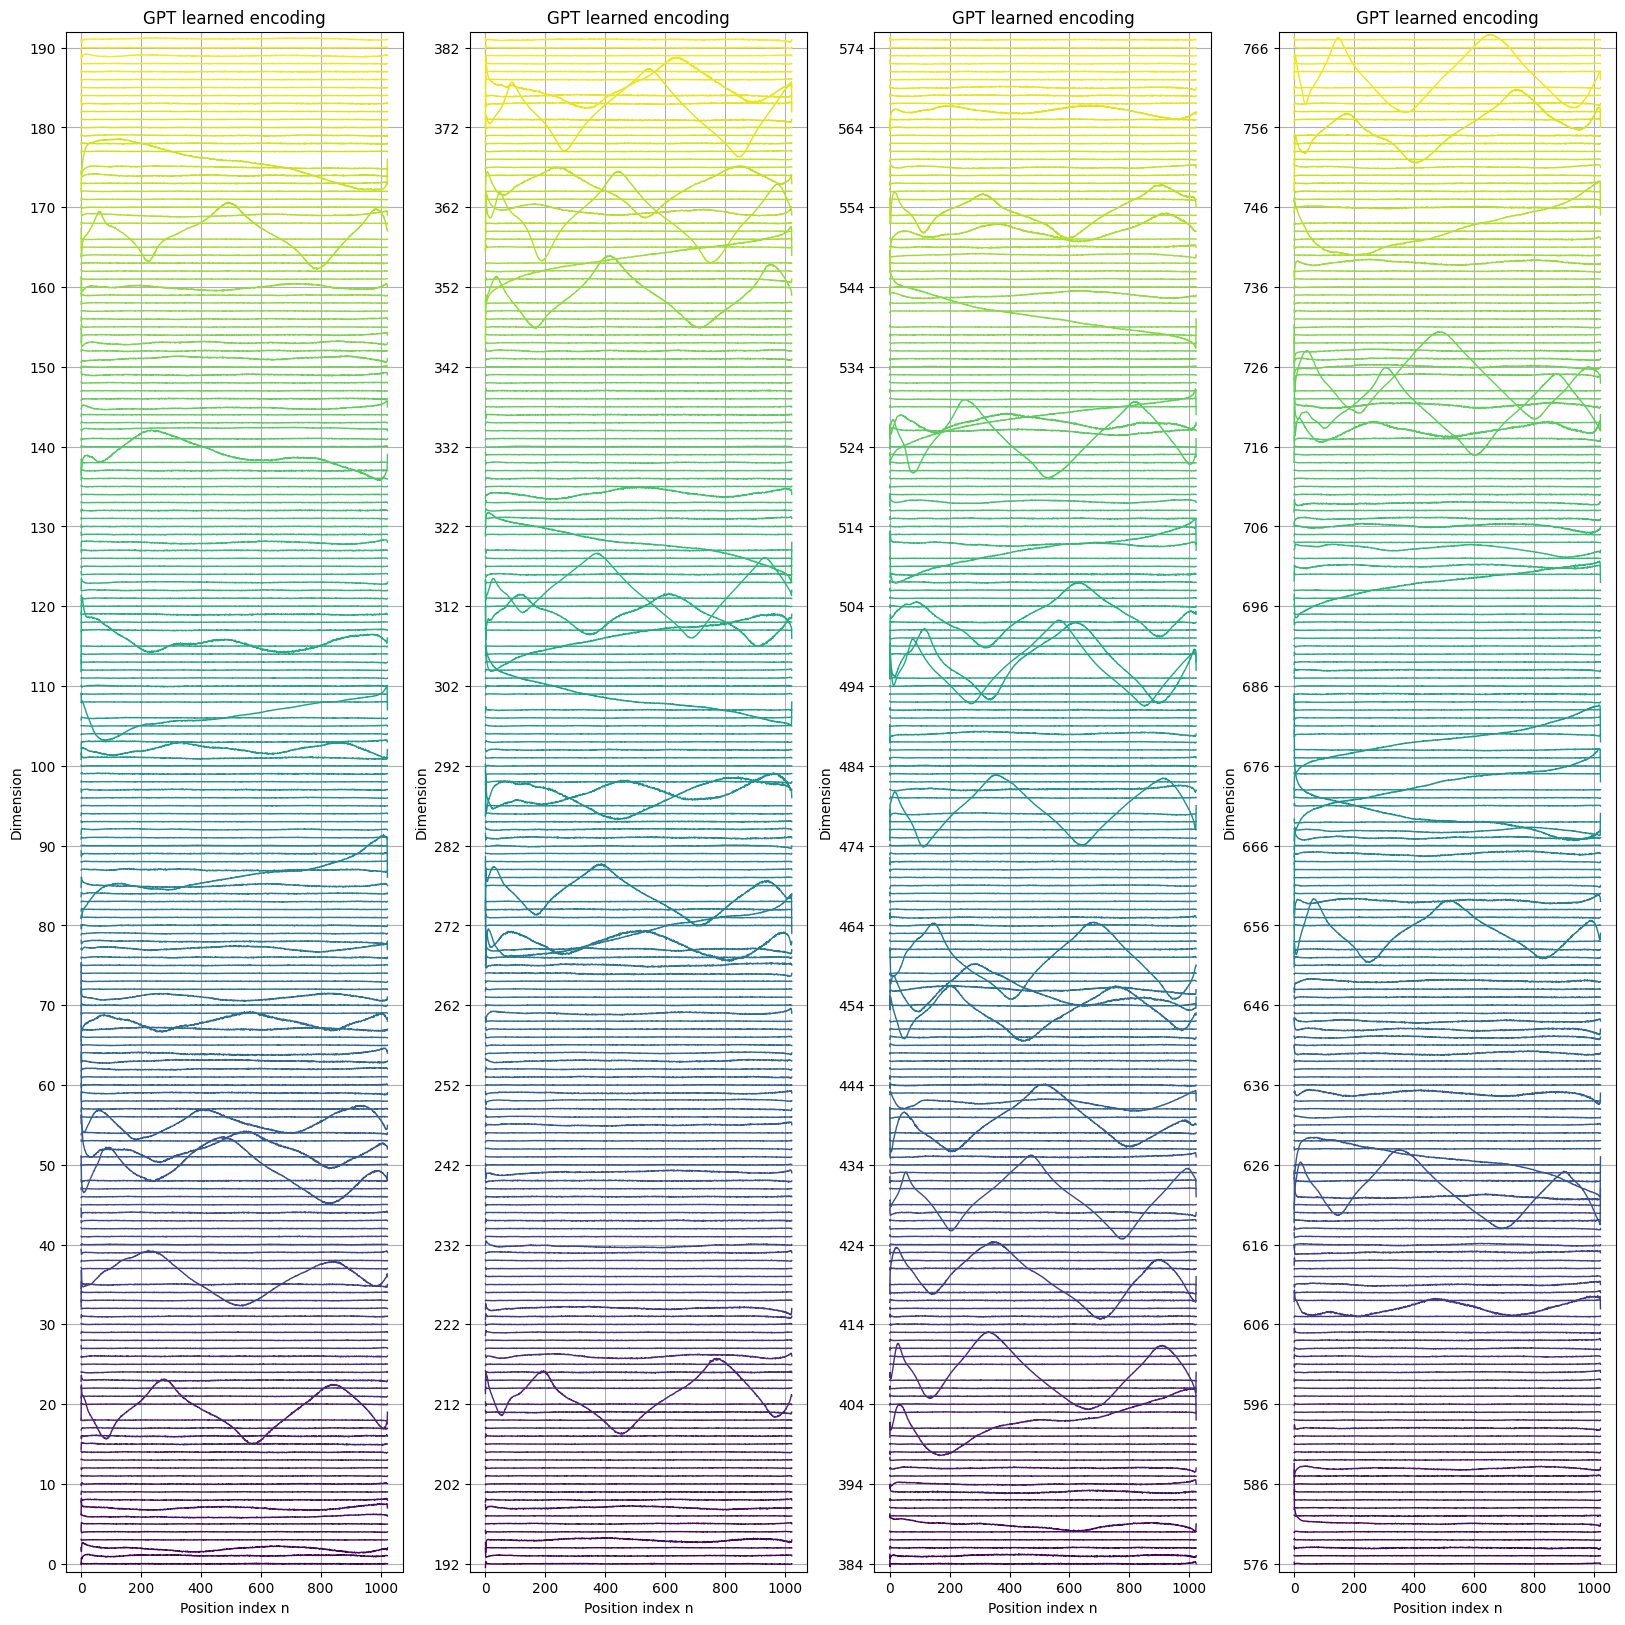

In [ ]:
def plot_encoding_notscaled(encoding, dims_to_plot, ax,title = "", l = 1):
    cmap = plt.get_cmap('viridis', len(dims_to_plot)) 
    offset = 0.2
    for i, dim in enumerate(dims_to_plot):
        p = encoding[:, dim]
        ax.plot(p + i * offset, color = cmap(i), linewidth = l)

    ax.set_xlabel("Position index n")
    ax.set_ylabel("Dimension")
    yticks_positions = np.arange(0, len(dims_to_plot), 10) * offset
    ax.set_yticks(yticks_positions)
    ax.set_yticklabels(dims_to_plot[::10])
    ax.set_ylim(-offset, len(dims_to_plot) * offset )
    ax.set_title(title)
    ax.grid()


fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 20))
dims_per_plot = 768//4
plot_encoding_notscaled(positional_encodings, dims_to_plot = np.arange(0, dims_per_plot), ax = axs[0], title = "GPT learned encoding")
plot_encoding_notscaled(positional_encodings, dims_to_plot = np.arange(dims_per_plot, 2*dims_per_plot), ax = axs[1], title = "GPT learned encoding")
plot_encoding_notscaled(positional_encodings, dims_to_plot = np.arange(2*dims_per_plot, 3*dims_per_plot), ax = axs[2], title = "GPT learned encoding")
plot_encoding_notscaled(positional_encodings, dims_to_plot = np.arange(3*dims_per_plot, 4*dims_per_plot), ax = axs[3], title = "GPT learned encoding")


In [ ]:
from scipy.fftpack import fft

def plot_fft_comparison(encoding, pos_idx=0):
    signal = encoding[pos_idx]
    freq = np.abs(fft(signal))
    plt.plot(freq)
    plt.title(f"FFT of Encoding at Position {pos_idx}")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.show()

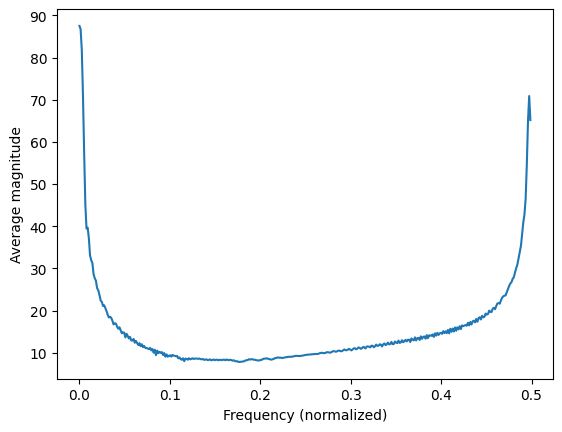

In [29]:
import numpy as np

# Suppose `data` is your 2D matrix: rows = signals, columns = time samples
#data = positional_encodings  # shape (num_signals, num_samples)
data = sinusoidal_encodings

# FFT parameters
num_signals, num_samples = data.shape
freqs = np.fft.fftfreq(num_samples)  # frequency bins (normalized)
positive_freqs = freqs[:num_samples // 2]  # keep positive frequencies

# Compute FFT magnitude for each row
fft_vals = np.fft.fft(data, axis=1)
fft_magnitude = np.abs(fft_vals[:, :num_samples // 2])  # positive freq magnitudes

# Option 1: Sum magnitude over signals per frequency bin
avg_spectrum = np.mean(fft_magnitude, axis=0)

# Option 2: Flatten all magnitudes and build histogram
all_freq_magnitudes = fft_magnitude.flatten()

# Choose bins for the histogram (for frequencies or magnitudes)
# Example: histogram of frequency magnitudes
hist, bin_edges = np.histogram(all_freq_magnitudes, bins=50)

# If you want histogram over frequencies weighted by magnitude:
# Use `positive_freqs` repeated per signal, weighted by magnitude.

# Example plotting average spectrum
import matplotlib.pyplot as plt
plt.plot(positive_freqs, avg_spectrum)
plt.xlabel('Frequency (normalized)')
plt.ylabel('Average magnitude')
plt.show()